In [21]:
import gym
import os
from stable_baselines.results_plotter import load_results
from seagul.plot import smooth_bounded_curve
from seagul.mesh import create_mesh
import matplotlib.pyplot as plt
import numpy as np
import torch
import pybullet_envs
from stable_baselines import TD3 as ALGO
import time
import seagul.envs
import pybullet as p
import json
import pybulletgym
from seagul.envs.wrappers import PyBulletPhysicsWrapper
from seagul.mesh import *

env_name = "Walker2d-v2"
#env_name = "Walker2DBulletEnv-v0"
#env_name = "pbmj_walker2dfc-v0"
#env_name = "Walker2DMuJoCoEnv-v0"

def do_rollout_stable(init_point=None, render=False, video=False):
    env = gym.make(env_name)
    #env = PyBulletPhysicsWrapper(gym.make(env_name, render=render), **config)
    model.observation_space = env.observation_space
    obs=env.reset()
    #td3_model = TD3.load(script_path + "../rl-baselines-zoo/baseline_log2/td3/su_acrobot_cdc-v0_2/su_acrobot_cdc-v0.zip")

    obs = torch.as_tensor(obs, dtype=torch.float32)

    acts_list = []
    obs1_list = []
    rews_list = []
    img_list = []

    dtype = torch.float32
    act_size = env.action_space.shape[0]
    obs_size = env.observation_space.shape[0]

    done = False
    cur_step = 0

    while not done:
        acts = model.predict(obs)[0]
        obs, rew, done, out = env.step(acts)
  
        if render:
            env.render()
            
        obs1_list.append(obs)
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(acts))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        cur_step += 1

    ep_obs1 = torch.tensor(obs1_list)
    ep_acts = torch.stack(acts_list)
    ep_rews = torch.stack(rews_list)

    return ep_obs1, ep_acts, ep_rews, img_list

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


<Figure size 432x288 with 0 Axes>

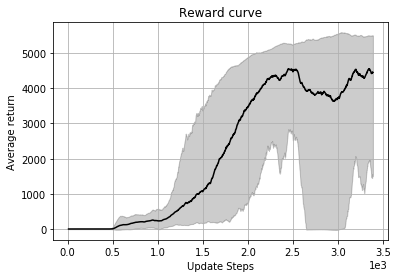

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [22]:
# %%
fig, ax = plt.subplots(1,1)

#log_dir = script_path + './walker_log'
df_list = []
model_list = []
min_length = float('inf')

trial_path = "/home/sgillen/work/contact/run_stable/data2/zoo_td3_mon/"
trial_path = "/home/sgillen/work/contact/run_stable/data_pbdp/td3/dantzig_200/"
trial_path = "/home/sgillen/work/contact/run_stable/data_mjw/td3/mj_1/"
#trial_path = "/home/sgillen/work/contact/run_stable/data_pbdp/td3/low_solve/"



#trial_path = "/home/sgillen/work/contact/run_stable/data_pbp/td3/not_dantzig/"
#trial_path = "/home/sgillen/work/contact/run_stable/data_pbp/td3/rest_35_long"
#trial_path = "/home/sgillen/work/contact/run_stable/data_pbp/td3/not_dantzig"


for entry in os.scandir(trial_path):
    if ".ipynb" in entry.path:
        continue
    if "config" in entry.path:
        config = json.load(open(entry.path))
        continue
    
    df = load_results(entry.path)


    if len(df['r']) < min_length:
        min_length = len(df['r'])

    #plt.plot(df['r'])
    plt.figure()
    df_list.append(df)
    model_list.append(ALGO.load(entry.path + "/model.zip"))

min_length = int(min_length)
rewards = np.zeros((min_length, len(df_list)))

for i, df in enumerate(df_list):
    rewards[:, i] = np.array(df['r'][:min_length])

smooth_bounded_curve(rewards[:min_length], ax=ax)
 
ax.grid()
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
#fig.savefig(script_path + '../figs/reward.png')
plt.figure() 

In [ ]:
trial_num = 0

model = model_list[trial_num]
df = df_list[trial_num]
plt.plot(df['r']); plt.show()

obs_hist, act_hist, rew_hist, img_list = do_rollout_stable(render=False, video=False)

print(f"reward sum: {sum(rew_hist)}")

plt.step([i for i in range(act_hist.shape[0])], act_hist, 'k')
plt.title('Actions')
plt.xlabel('Time (seconds)')
plt.ylabel('Torque (Nm)')
plt.grid()
#plt.savefig(script_path + '../figs/act_hist.png')
plt.show(); plt.figure()

plt.plot(obs_hist)

plt.title('States')
plt.xlabel('Time ticks')
plt.ylabel('States (mixed units)')
plt.grid()
#plt.savefig(script_path + '../figs/obs_hist.png')
plt.show()

In [23]:
experiment_paths = ["/home/sgillen/work/contact/run_stable/data_mjw/td3/mj_1/"]

#experiment_paths = ["/home/sgillen/work/contact/run_stable/data2/zoo_td3_mon/",
#                    "/home/sgillen/work/contact/run_stable/data_pbdp/td3/dantzig_200/", 
#                    "/home/sgillen/work/contact/run_stable/data_pbdp/td3/high_solve_200/",
#                    "/home/sgillen/work/contact/run_stable/data_pbdp/td3/low_solve/"]

num_seeds = 8
num_trials = 100

fail_count = np.ones((len(experiment_paths), num_seeds))*-1

mesh_dims = np.ones((len(experiment_paths), num_seeds, num_trials))*-1
c_mesh_dims = np.ones((len(experiment_paths), num_seeds, num_trials))*-1
var_dims = np.ones((len(experiment_paths), num_seeds, num_trials))*-1

exception_list = []


for experiment_num, experiment_path in enumerate(experiment_paths):
    model_list = []
    for entry in os.scandir(experiment_path):
        if ".ipynb" in entry.path:
            continue
        if "config" in entry.path:
            config = json.load(open(entry.path))
            continue

        model_list.append(ALGO.load(entry.path + "/model.zip"))

    for seed_num in range(num_seeds):
        model = model_list[seed_num]
        for trial in range(num_trials):
            obs_hist, act_hist, rew_hist, img_list = do_rollout_stable(render=False, video=False)
            if obs_hist.shape[0] < 1000:
                fail_count[experiment_num, seed_num]+=1
                continue
                
            #try:
            X = obs_hist[100:, :]
            mesh_dims[experiment_num, seed_num, trial],_,_ = mesh_dim(X)
            c_mesh_dims[experiment_num, seed_num, trial],_,_ = conservative_mesh_dim(X)
            var_dims[experiment_num, seed_num, trial]  = variation_dim(X)
        #except:
            #    exception_list.append((experiment_num, seed_num, trial))

Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.
Loading a model without an environment, this model cannot be trained until it has a valid environment.


/home/sgillen/miniconda3/envs/stable/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Save Video

In [ ]:
obs_hist, act_hist, rew_hist, img_list = do_rollout_stable(render=False, video=True)

from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(img_list, fps=60)
clip.write_gif("walker2.gif", fps=60)

# Meshing / Dimensionality

In [ ]:
useful_states = [0, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
X=obs_hist[100:, useful_states]
#X=obs_hist

In [ ]:
mesh, weights = create_mesh(X, .1)
mesht = np.stack(mesh)
weights =np.stack(weights)

In [ ]:
start = time.time()

d = 1e-3 # initial d, requires hand tuning for now
mesh_sizes = []
d_vals = []
while True:
    mesh,_ = create_mesh(X,d)
    mesh_sizes.append(len(mesh))
    d_vals.append(d)

    if mesh_sizes[-1] == 1:
        break

    d = d*2

print(time.time() - start)

In [ ]:
import scipy.optimize as opt

for i, m in enumerate(mesh_sizes):
    if m < X.shape[0]:
        lin_begin = i+1
        break

xdata = np.array(d_vals[lin_begin:])
ydata = np.array(mesh_sizes[lin_begin:])

plt.plot(xdata, ydata, 'kx--')
#plt.plot(d_vals, mesh_sizes, 'kx--')
plt.title("Mesh sizes")
plt.xlabel('log(d)')
plt.ylabel('log(Points in mesh)')
plt.yscale('log')
plt.xscale('log')
plt.gca().xaxis.grid(True, which='both')  # minor grid on too
plt.gca().yaxis.grid(True, which='both')  # minor grid on too
plt.figure()

# %%
def f(x, m, b):
    return m * x + b

popt, pcov = opt.curve_fit(f, np.log10(xdata), -np.log10(ydata))

plt.plot(np.log10(xdata), -np.log10(ydata), 'kx')
plt.plot(np.log10(xdata), f(np.log10(xdata), *popt), 'r--')
plt.title("Linear Fit ")
plt.legend(['Data', 'fit: m*x + b,  m=%5.3f, b=%5.3f' % tuple(popt)])
plt.xlabel('log(d)')
plt.ylabel('log(Points in mesh)')
plt.gca().xaxis.grid(True)  # minor grid on too
plt.gca().yaxis.grid(True)  # minor grid on too
plt.show()

In [ ]:
def mesh_dim(X):
    d = 1e-3 # initial d, requires hand tuning for now
    mesh_sizes = []
    d_vals = []
    while True:
        mesh,_ = create_mesh(X,d)
        mesh_sizes.append(len(mesh))
        d_vals.append(d)

        if mesh_sizes[-1] == 1:
            break

        d = d*2
    
    
    for i, m in enumerate(mesh_sizes):
        if m < X.shape[0]:
            lin_begin = i
            break

    xdata = np.array(d_vals[lin_begin:])
    ydata = np.array(mesh_sizes[lin_begin:])

    def f(x, m, b):
        return m * x + b

    popt, pcov = opt.curve_fit(f, np.log10(xdata), np.log10(ydata))
    
    return -popt[0]
 

In [ ]:
def V(X,l,ord):
    return 1 / (2 * len(X) - l) * np.sum(np.linalg.norm(X[l:] - X[:-l],ord=ord))

def D(X, order=1):
    return 2 - 1/(order*np.log(2))*(np.log(V(X,2,order)) - np.log(V(X,1,order)))



--- "more" ---
[0]:  z - self.initial_z,
[1]:  np.sin(angle_to_target),
[2]:  np.cos(angle_to_target),
[3]:  0.3 * vx,
[4]:  0.3 * vy,
[5]:  0.3 * vz,  # 0.3 is just scaling typical speed into -1..+1, no physical sense here
[6]:  r, # body roll
[7]:  p  # body pitch
--- "joint variables" ---- (joint range refers the physical range allowed by the sim, each joint is scaled so -1 is the lower joint limit, and +1 is the higher joint limit)
[8]:  thigh_joint relative angle (scaled to -1 1) (joint range -2.61 0.0) (this is the green thigh when rendered)
[9]:  thigh_joint relative velocity*.1 
[10]: leg_joint relative angle (scaled -1 1) (joint range -2.61 0.0)
[11]: leg_joint relative velocity*.1
[12]: foot_joint relative angle (scaled to -1 1) (joint range -.785 .785)
[13]: foot_joint relative velocity*.1
[14]: thigh_left_joint relative angle (scaled to -1 1) (joint range -2.61 0.0) (this is the red thigh when rendered)
[15]: thigh_left_joint relative velocity*.1 
[16]: leg_left_joint relative angle (scaled -1 1) (joint range -2.61 0.0)
[17]: leg_left_joint relative velocity*.1
[18]: foot_left_joint relative angle (scaled to -1 1) (joint range -.785 .785)
[19]: foot_left_joint relative velocity*.1
--- "foot contact" ----
[20]: robot.feet_contact[0] # right foot, green
[21]: robot.feet_contact[2] # left foot, red

states = [ 
[0]:  z - self.initial_z,
[1]:  np.sin(angle_to_target),
[2]:  np.cos(angle_to_target),
[3]:  0.3 * vx,
[4]:  0.3 * vy,
[5]:  0.3 * vz,  # 0.3 is just scaling typical speed into -1..+1, no physical sense here
[6]:  r, # body roll
[7]:  p  # body pitch
--- "joint variables" ---- (joint range refers the physical range allowed by the sim, each joint is scaled so -1 is the lower joint limit, and +1 is the higher joint limit)
[8]:  thigh_joint relative angle (scaled to -1 1) (joint range -2.61 0.0) (this is the green thigh when rendered)
[9]:  thigh_joint relative velocity*.1 
[10]: leg_joint relative angle (scaled -1 1) (joint range -2.61 0.0)
[11]: leg_joint relative velocity*.1
[12]: foot_joint relative angle (scaled to -1 1) (joint range -.785 .785)
[13]: foot_joint relative velocity*.1
[14]: thigh_left_joint relative angle (scaled to -1 1) (joint range -2.61 0.0) (this is the red thigh when rendered)
[15]: thigh_left_joint relative velocity*.1 
[16]: leg_left_joint relative angle (scaled -1 1) (joint range -2.61 0.0)
[17]: leg_left_joint relative velocity*.1
[18]: foot_left_joint relative angle (scaled to -1 1) (joint range -.785 .785)
[19]: foot_left_joint relative velocity*.1
--- "foot contact" ----
[20]: robot.feet_contact[0] # right foot, green
[21]: robot.feet_contact[2] # left foot, red

In [ ]:

state_names  = [ 
"z - self.initial_z",
"np.sin(angle_to_target)",
"np.cos(angle_to_target)",
"0.3 * vx",
"0.3 * vy",
"0.3 * vz", 
"r, # body roll",
"p  # body pitch",
"thigh_joint angle",
"thigh_joint velocity*.1 ",
"leg_joint angle",
"leg_joint velocity",
"foot_joint angle",
"foot_joint velocity*.1",
"thigh_left_joint angle",
"thigh_left_joint velocity*.1 ",
"leg_left_joint angle",
"leg_left_joint velocity*1",
"foot_left_joint angle",
"foot_left_joint velocity*.1",
"robot.feet_contact[0]",
"robot.feet_contact[2]"
]


In [ ]:
env = gym.make(env_name)
from itertools import product
n_states = env.observation_space.shape[0]
fig, ax = plt.subplots(n_states,n_states, figsize=(64,64))

for i, j in product(range(n_states), range(n_states)):
    ax[i,j].scatter(mesht[:,i], mesht[:,j])

In [ ]:
env = gym.make(env_name)
from itertools import product

n_states = len(useful_states)
meshu = mesht[:,useful_states]
v_dims = np.zeros((n_states, n_states))
m_dims = np.zeros((n_states, n_states))


fig, ax = plt.subplots(n_states,n_states, figsize=(64,64))

for i, j in product(range(n_states), range(n_states)):
    ax[i,j].scatter(meshu[:,i], meshu[:,j])
    m_dims[i,j] = mesh_dim(np.stack((meshu[:,i], meshu[:,j]), axis=1))
    v_dims[i,j] = D(np.stack((X[:,i], X[:,j]), axis=1))
    ax[i,j].set(title=str(m_dims[i,j]))

In [ ]:
env = gym.make(env_name)
from itertools import product

useful_states = [0, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
n_states = len(useful_states)
meshu = mesht[:,useful_states]
v_dims = np.zeros((n_states, n_states))
m_dims = np.zeros((n_states, n_states))


fig, ax = plt.subplots(n_states,n_states, figsize=(64,64))

for i, j in product(range(n_states), range(n_states)):
    ax[i,j].scatter(meshu[:,i], meshu[:,j])
    #m_dims[i,j] = mesh_dim(np.stack((meshu[:,i], meshu[:,j]), axis=1))
    v_dims[i,j] = D(np.stack((X[:,i], X[:,j]), axis=1))
    ax[i,j].set(title=str(v_dims[i,j]))

# Manifold Learning

In [ ]:

print(__doc__)

from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
#X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
#methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

# %%

In [ ]:
folder = "/home/sgillen/work/contact/run_stable/tmp_video"
import matplotlib.cm as cm
import subprocess
import glob

def generate_video(img):
    for i in range(len(img)):
        plt.imshow(img[i], cmap=cm.Greys_r)
        plt.savefig(folder + "/file%02d.png" % i)

    os.chdir(folder)
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

In [ ]:
import cv2

#fourcc = cv2.VideoWriter_fourcc(*'X264')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
#fourcc = cv2.VideoWriter_fourcc(*'MJPG')

video_dir = "./tmp_video/"
text = "/".join(trial_path.split("/")[4:]) + "--" + "trial_" + str(trial_num)
video = cv2.VideoWriter(video_dir + "video.mp4", fourcc, 60, (img_list[0].shape[1],img_list[0].shape[0]))
assert(video.isOpened())

for frame in img_list:
    position = (5,230)
    frame = cv2.putText(frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, .25, (0, 0, 0, 0), 1)
    frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
    video.write(frame)
    
video.release()

# Distance Stuff

In [ ]:
def sgidw(x, mesh, weights, order=1, min_dist=.1):
    d = np.clip((np.linalg.norm(mesh - x, axis=1)), min_dist, float('inf'))**order
    w = 1/d
    return weights.dot(w)

def shepard(x, mesh, weights, order=1, min_dist=.1):
    d = np.clip((np.linalg.norm(mesh - x, axis=1)), min_dist, float('inf'))**order
    w = 1/d
    return weights.dot(w)/np.sum(w)

def modified_shepard(x, mesh, weights, order=1, r=15, min_dist=.1):
    d = np.clip((np.linalg.norm(mesh - x, axis=1)**order), min_dist, float('inf'))**order
    w = (np.clip(r-d,0,float('inf'))/(r*d))**2
    if np.sum(w) == 0:
        return 0
    else:
        return weights.dot(w)
    
    

In [ ]:
from itertools import product
 
n_p = 100
z = 0
r = 10

dim1 = 11; dim2 = 12

x_vals = np.linspace(1, -1, n_p)
y_vals = np.linspace(1, -1, n_p)

coords = np.zeros((n_p, n_p, 4), dtype=np.float32)
sg = np.zeros((n_p, n_p))
sh = np.zeros((n_p, n_p))
msh = np.zeros((n_p, n_p))


for i, j in product(range(n_p), range(n_p)):
    point = np.zeros(mesht.shape[1])
    point[dim1] = x_vals[j]
    point[dim2] = y_vals[i]


    sg[i,j] = sgidw(point, mesht, weights, order=2, min_dist=.25)
    msh[i,j] = modified_shepard(point, mesht, weights, order=2, min_dist=.25)


for z in [sg,sh,msh]:
    fig, ax = plt.subplots(1,1, figsize=(8, 8))
    x, y = np.meshgrid(x_vals, y_vals)
    z = z[:-1, :-1]
    c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z.min(), vmax=z.max())
    ax.scatter(mesht[:,dim1], mesht[:,dim2],color='k')
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)

In [ ]:
mesht.shape